# 第三週：基本文字資料的處理 (中文)

本週課程為「基本文字資料的處理」，目的為了解基本的文字處理概念。文字處理的步驟會因所要分析之語言不同而有所差異，在這個Jupyter Notebook當中將會展示「中文」的文字處理過程，並且搭配python程式碼進行講解。在後面的內容中，我們將會介紹所使用到的套件、文字處理基本流程、實際應用等三個部分。

## 大綱
1. 套件說明
2. Tidy Data 示範
3. 文字處理基本流程示範
    - 3.1 建立示範中文文本
    - 3.2 中文斷詞
    - 3.3 去除停用字
4. 實際應用(Ptt文章)
    - 4.1 中文斷詞
    - 4.2 去除停用字
    - 4.3 更新斷詞及停用字詞典
    - 4.4 結果比較

## 1. 套件說明

下面列出在本次實作過程中我們所使用到的相關套件，在這個Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。

- Pandas : 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- jieba : 中文斷詞套件
- re : 正規表達式套件。
- wordcloud : 文字雲繪圖工具。
- matplotlib : 繪圖工具。

### 初始環境設置

在提供的資料夾中包含```requirements.txt```檔案，裡面列出了大部分本堂課會使用到的套件與對應版本。  

建置環境時可以透過在 Terminal 輸入以下指令安裝套件：   

```pip install -r requirements.txt```

### Google Colab 套件安裝   
這次會使用到的套件Colab都內建好了，若在Google Colab環境下要安裝套件的話須在指令前加驚嘆號。  

eg. !pip install -r requirements.txt


註：Google Colab 的相關操作可以參考網大的介紹影片

In [17]:
# !pip install -r requirements.txt
# !pip install pandas

### 套件相關錯誤的解決方法

若在執行時有遇到套件相關的錯誤，可以在 Terminal 執行以下指令查看套件的版本是否與 requirements.txt 清單中的版本相符：

```pip list```：查看所有套件版本    

```pip show 套件名稱```：查看指定套件的相關資訊   

假如發現套件版本不相符，則可以使用以下指令先移除該套件再重新安裝指定版本：

```pip uninstall 套件名稱 -y```：移除指定套件

```pip install 套件名稱==套件版本```：安裝特定版本    


引入套件

In [3]:
import pandas as pd
import jieba
import jieba.analyse
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

繪圖相關設定

In [4]:
# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
# plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] # MacOS 內建中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # Windows 中文字體

# 設定文字雲中文字體路徑
FontPath = 'raw_data/SourceHanSansTW-Regular.otf' # 設定字型

## 2. Tidy Data
在進行資料分析的過程當中，資料清理是一個不可或缺的環節，資料清理的精細程度也會直接影響結果好壞。   
而在機器學習的領域當中，我們通常會將文字型資料(Textual Data)視為是一種非結構化資料(Unstructure Data)。   

這樣的非結構化資料是需要透過特定的清理方式將其轉為結構化資料之後，才能夠為後續分析使用。   
這樣的處理方式我們將其稱為Data Tidying。而處理過後的「乾淨」的資料，我們就把它叫做Tidy Data。其定義的原則如下：

1. 每個變數分別在個別的欄位。
2. 每筆觀察值形成一列。
3. 不同主題要用不同table來整理。

接著我們用一個範例來介紹Tidy Data。

下面圖片中的兩個表格是使用相同的資料，但不同的表達方式。其概念都是要用來描述不同的人(person)在不同的實驗(treatmenta, treatmentb)當中的結果(表格中的數字)。

<img src="./pic/untidy.png" alt="untidy_table" width="400"/>

而這樣的資料其實是不利於資料分析的進行的。我們用剛才所定義的原則來將資料轉換為Tidy Data(如下圖中的表格)，可以看到資料其實是包含了三個變數、六個觀察值。也就是說我們可以用一個Pandas的DataFrame來表達資料。

<img src="./pic/tidy_table.png" alt="tidy_table" width="400"/>

#### Tidy Data 小練習
我們將建立出一個Pandas DataFrame的物件來儲存資料，這裡用Python Dict來建立DataFrame。   
Dict裡的key值(下面的treatment、John Smith...)對應到一個欄位的名稱，而其值(value)則是其欄位裡的所有值。

In [ ]:
treatmentData = pd.DataFrame({
    'treatment':['a', 'b'],
    'John Smith':[None, 2],
    'Jane Doe':[16, 11],
    'Mary Johnson':[3, 1]
})
treatmentData

,treatment,John Smith,Jane Doe,Mary Johnson
0,a,NaN,16,3
1,b,2.0,11,1


將以上非Tidy 格式的dataframe使用pandas的function將其轉換成Tidy格式

In [ ]:
# pd.melt -> 用來將寬格式轉換為長格式
# id_vars 指定 treatment 欄位不變
# 其他欄位（John Smith, Jane Doe, Mary Johnson）會被壓縮成兩個欄位：
# 1. variable（原本的欄位名稱）
# 2. value（對應的數值）
treatmentData_melt = pd.melt(treatmentData, id_vars=['treatment'])
treatmentData_melt

,treatment,variable,value
0,a,John Smith,NaN
1,b,John Smith,2.0
2,a,Jane Doe,16.0
3,b,Jane Doe,11.0
4,a,Mary Johnson,3.0
5,b,Mary Johnson,1.0


接著去除資料中的空值

In [7]:
treatmentData_melt = treatmentData_melt.dropna(subset=['value'])
treatmentData_melt

,treatment,variable,value
1,b,John Smith,2.0
2,a,Jane Doe,16.0
3,b,Jane Doe,11.0
4,a,Mary Johnson,3.0
5,b,Mary Johnson,1.0


查看兩種 treatment 的出現次數

In [ ]:
# as_index -> 讓groupby 結果保持 DataFrame 格式，而不是變成索引（index）格式。
# size() -> 計算大小
# sum() -> 計算總和
treatmentData_melt.groupby(by = ['treatment'], as_index = False).size()

,treatment,size
0,a,2
1,b,3


分析或處理資料時經常會使用```groupby```函式來對資料進行分群。   

更多相關的使用方法可參考[官網](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)

<img src="./pic/pandas-groupby.svg" alt="pandas groupby illustration" width="500"/>

```Method Chaining```  

Method chaining是一種程式碼的撰寫風格，將某一段程式碼產生的結果直接導向另一段程式碼，使程式碼更加簡潔、好讀。  
使用pandas套件時也可以利用此方法，讓上述的好幾行程式碼整合成以下的樣子：

In [24]:
treatment_count = treatmentData.melt(id_vars=['treatment']).dropna(subset=['value']).groupby(by = ['treatment'], as_index = False).size()
treatment_count

,treatment,size
0,a,2
1,b,3


## 3. 文字處理基本流程
接下來的章節我們將介紹文字處理的基本流程。其中大概可以分為六個步驟

+ **資料蒐集：** <br>
如同上面所述，文字型資料被視為是一種非結構化的資料。   
其資料來源相當的廣泛，如：論壇、新聞網、社群媒體、專利、論文等...。   
其中，論壇、新聞網、社群媒體這類由使用者所產生出來的資料我們將其稱為User Generated Data(UGC)。    
通常來說，我們會使用網路爬蟲的技術來取得這樣的資料(網路爬蟲的技術不會在此範例中討論)。 <br><br>
+ **資料初步清理：** <br>
將文字內容轉為正規的語句，例如：去除特定標籤、符號、統一標點符號的使用等等。<br><br>
+ **斷句斷詞：** <br>
使用工具區隔文章中不同的句子、詞彙 <br><br>
+ **去除停用字：** <br>
停用字就是與分析無關的詞彙，甚至這些詞彙可能會影響分析的結果。   
因此我們必須在資料處理的過程中將其排除。例如：語助詞 <br><br>
+ **產生結構化資料：** <br>
根據需求產生不同結構化資料(Tidy Data)，以供後續分析使用。 <br><br>
+ **應用更多分析：** <br>
進行不同的分析，例如：詞頻分析、情緒分析、文辭和文件分析、文件分類、社會網路分析等等。

### 3.1 建立示範文本

In [34]:
chinese_text = """近幾年來「良心投資」逐漸形成一股風潮，投資人對於企業社會責任愈來愈重視，環境保護、社會責任與公司治理加總的ESG概念，
                也成為當今華爾街和法人投資圈最熱門的熱搜關鍵英文縮寫。什麼是「ESG」？就是環境保護（Environmental）、社會責任（Social）與公司治理（Governance）
                這3個英文字的縮寫，從政府推動限塑政策、上市公司需編製與申報企業社會責任報告書、民間團體自動發起淨灘活動等，背後都蘊含著ESG的意涵。
                ESG投資可以回溯到2006年聯合國責任投資原則（UNPRI）的成立，致力於推動全球各大投資機構在投資決策過程中必須納入ESG因子，
                並協助PRI的簽署國家全面提升責任投資的能力。戮力經營本業的企業，若不重視ESG，就算有好的本益比、好的成長，也會影響公司價值，
                尤其是近年來環境變遷等「無差別衝擊」影響企業經營表現，投資人轉向從ESG、SDGs（聯合國永續發展目標）等評價模式尋找投資標的。"""

example_df = pd.DataFrame({'text': [chinese_text]})
example_df

,text
0,近幾年來「良心投資」逐漸形成一股風潮，投資人對於企業社會責任愈來愈重視，環境保護、社會責任與...


### 3.2 中文斷詞

斷詞引擎設定：使用 Jieba 當作斷詞系統。

Jieba原先內建為簡體字字典，但我們可以使用繁體字典來做為替換，結果會比較好。   
另外可能還有一些專有名詞是沒有被包含在預設字典當中，我們也可以使用自定義字典的方式加入，或者使用參數的形式帶入。

In [35]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt
jieba.set_dictionary('./dict/dict.txt') 

# 載入自定義辭典：一個詞一行，每行分詞語、詞頻(可省)、詞性(可省)
jieba.load_userdict('./dict/example_user_dict.txt')

# 參數形式手動將字詞加入斷詞字典
words = ['良心投資','投資圈','熱搜','公司治理']
for w in words:
    jieba.add_word(w, freq=None, tag=None)

Building prefix dict from e:\中山資管碩\碩一下學期\社媒\SMA_2025S\week03\dict\dict.txt ...
Loading model from cache C:\Users\paul\AppData\Local\Temp\jieba.uca9dafc5f43f35e52d32454dcff9134c.cache
Loading model cost 0.780 seconds.
Prefix dict has been built successfully.


使用jieba套件的斷詞函式來實作斷詞，並利用pandas套件將文件整理成我們要的格式。步驟解釋如下：

+ ```assign``` : 新增一個欄位「word」，值為 example_df['text'] 進行jieba.lcut的結果

+ ```apply``` : 將jieba.lcut函式應用於 example_df['text'] 的每一行。

+ ```explode``` : jieba.lcut的結果為list，因此用explode將list裡的每個值變單獨一行

+ ```drop``` : 將欄位「text」刪除，axis=1為對縱軸操作(column)，axis=0為對橫軸操作(row)


***大家可以試著將explode()或drop()拿掉，看看結果有什麼變化***

In [36]:
example_df = example_df.assign(word = example_df['text'].apply(jieba.lcut)).explode('word').drop(['text'], axis=1)
example_df.head(10)

,word
0,近
0,幾年
0,來
0,「
0,良心投資
0,」
0,逐漸
0,形成
0,一股
0,風潮


### 3.3 移除停用字（無意義的字、標點符號）

In [39]:
# 匯入檔案形式
stopwords = []

# 對於這段文字所定義的停用字列表
with open(f'./dict/text_stopwords.txt','r',encoding="utf8") as f:
    stopwords = f.read().splitlines() #移除換行符號\n

# 參數形式手動加入停用字
user_stop = ["的", "來", "對於", "愈來愈", "就是", "什麼"]
for i in user_stop:
    stopwords.append(i)

print(stopwords)

['，', '「', '」', '、', '。', '？', '（', '）', '"', '的', '來', '對於', '愈來愈', '就是', '什麼']


篩選掉word欄位裡的停用字

In [ ]:
# ~ : 取出相反->得到沒有停用字的內容
example_df = example_df[~example_df['word'].isin(stopwords)]
example_df.head(10)

,word
0,近
0,幾年
0,良心投資
0,逐漸
0,形成
0,一股
0,風潮
0,投資人
0,企業社會責任
0,重視


除了停用字字典以外，也可另外使用其他篩選條件，如：字詞長度小於2則不納入考慮

In [41]:
example_df = example_df[example_df['word'].str.len() > 1]
example_df.head(10)

,word
0,幾年
0,良心投資
0,逐漸
0,形成
0,一股
0,風潮
0,投資人
0,企業社會責任
0,重視
0,環境保護


在Python中的資料表可使用Pandas DataFrame儲存，Pandas套件也提供了許多的函數可以進行資料的轉換與操作

有關DataFrame的操作可參考Pandas官網的[教材](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html)

## 4. 實際應用：以PTT美食版的文本為例

網路爬蟲的技術不會在此範例中討論，在後續的範例中，我們將以透過 TarFlow 爬取下來的PTT文章來說明文字分析的技術。

同學們後續自己練習時也可以使用其他資料！

### 4.1 資料介紹
資料來源：
+ TarFlow 蒐集PTT 美食版(Food)文章
+ 關鍵字：「吃到飽」
+ 時間： 2020-01-01 ~ 2022-12-31
+ 資料筆數：共 1630 篇文章

**註：取得資料的方式請參考 TarFlow 資料匯入教學影片**

讀取ptt檔案zh_buffet_20_22.csv

In [48]:
df = pd.read_csv('raw_data/zh_buffet_20_22.csv')
df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,ideos,Food,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,[],111.250.1.231,2020-01-02 00:21:09,ptt
1,2,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,[抱怨]ATT4FUN乾杯點沙朗多注意,2020-01-02 16:42:10,justin81828,Food,餐廳名稱：乾杯\r\n\r\n 地址：ATT4FUN 乾杯\r\n 電話：02-8786...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""KKyosuke"", ""...",118.169.82.96,2020-01-03 00:22:27,ptt
2,3,https://www.ptt.cc/bbs/Food/M.1577985452.A.477...,[食記]台北大安區六張犁站捷運小慧涼麵,2020-01-02 17:11:29,v84454058,Food,餐廳名稱：小慧涼麵\r\n 消費時間：2018年/11月起多訪\r\n 地址：台北市...,[],123.194.196.149,2020-01-03 00:22:34,ptt
3,4,https://www.ptt.cc/bbs/Food/M.1578120136.A.276...,[食記]福岡-運河城旁國產牛燒肉-WEST,2020-01-04 06:36:14,Guyinkt,Food,消費時間：2019年/08月\r\n\r\n在運河城逛累了當然要吃東西補充體力了喔!\r\n...,[],220.134.201.135,2020-01-05 00:21:43,ptt
4,5,https://www.ptt.cc/bbs/Food/M.1578125940.A.9AA...,[食記]長榮皇璽桂冠艙飛機餐SEA-TPE聖誕好運,2020-01-04 08:12:57,Sherlock56,Food,店名：長榮皇璽桂冠艙飛機餐\r\n 地址：無\r\n 電話：無\r\n 營業時間...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""swatseal"", ""...",121.109.166.209,2020-01-05 00:21:43,ptt


### 4.2 資料初步清理
- 清除內文為空值的文章

- 透過觀察發現ptt的文章常用兩個換行符號作為句子的結尾，因此將兩個換行取代為句號。

- 清除不重要的字如換行、網址

In [54]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id', 'artUrl', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True) # inplace=False會回傳新的Dataframe，需要賦值接它

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','，', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\r','', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df.head(10)

,artTitle,artDate,artContent,sentence
0,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,餐廳名稱：濃咖哩， 消費時間：2019年1/12月， (例：2010年...
1,[抱怨]ATT4FUN乾杯點沙朗多注意,2020-01-02 16:42:10,餐廳名稱：乾杯\r\n\r\n 地址：ATT4FUN 乾杯\r\n 電話：02-8786...,餐廳名稱：乾杯，， 地址：ATT4FUN 乾杯， 電話：02-87860808， 消費...
2,[食記]台北大安區六張犁站捷運小慧涼麵,2020-01-02 17:11:29,餐廳名稱：小慧涼麵\r\n 消費時間：2018年/11月起多訪\r\n 地址：台北市...,餐廳名稱：小慧涼麵， 消費時間：2018年/11月起多訪， 地址：台北市大安區臥龍街...
3,[食記]福岡-運河城旁國產牛燒肉-WEST,2020-01-04 06:36:14,消費時間：2019年/08月\r\n\r\n在運河城逛累了當然要吃東西補充體力了喔!\r\n...,消費時間：2019年/08月，，在運河城逛累了當然要吃東西補充體力了喔!，，WEST最大的特...
4,[食記]長榮皇璽桂冠艙飛機餐SEA-TPE聖誕好運,2020-01-04 08:12:57,店名：長榮皇璽桂冠艙飛機餐\r\n 地址：無\r\n 電話：無\r\n 營業時間...,店名：長榮皇璽桂冠艙飛機餐， 地址：無， 電話：無， 營業時間：依機艙供餐時間為...
5,[食記]新北樹林宏壽司日本料理必吃招牌生魚丼,2020-01-04 10:07:32,網誌圖文版\r\nhttps://aovablog.com/2985/\r\n(圖多)\r\...,網誌圖文版， 日本料理，地址： 238新北市樹林區長壽街21-1號，營業時間： 11:30–...
6,[食記]台中新開幕平價火鍋-聊聊鍋物(東海店),2020-01-04 17:24:13,餐廳名稱：聊聊鍋物(東海店)\r\n 消費時間：2019年/12月\r\n 地址：台...,餐廳名稱：聊聊鍋物(東海店)， 消費時間：2019年/12月， 地址：台中市西屯區台...
7,[食記]Harbour漢來海港曼谷@BangkokICONSIAM,2020-01-05 05:21:47,這篇要分享的是~海鮮吃到飽餐廳Harbour，在台北大名鼎鼎的和來海港曼谷分店~\r\n\r...,這篇要分享的是~海鮮吃到飽餐廳Harbour，在台北大名鼎鼎的和來海港曼谷分店~，，圖文並茂...
8,[請益]台北500元以內的吃到飽,2020-01-05 09:59:19,中式為主的吃到飽 盡量不要火鍋 燒烤(因為自己弄很累又花時間)\r\n大台北地區\r\n新台...,中式為主的吃到飽 盡量不要火鍋 燒烤(因為自己弄很累又花時間)，大台北地區，新台幣$500元...
9,[食記][台南][東區]XM麻辣鍋德安店,2020-01-06 04:38:35,餐廳名稱：XM麻辣鍋 德安店\r\n消費時間：109年1月\r\n地址：701台南市東區中華...,餐廳名稱：XM麻辣鍋 德安店，消費時間：109年1月，地址：701台南市東區中華東路三段36...


### 4.3 斷句
中文主要以標點符號進行斷句，並清除空的字串

In [55]:
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)

sent_df.head(10)

,artTitle,artDate,artContent,sentence
0,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,餐廳名稱：濃咖哩
1,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,消費時間：2019年1/12月
2,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,(例：2010年7月
3,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,未提供則文章不予保留
4,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,多訪綜合心得也請標上起迄時間)
5,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,地址：台北市開封街1段78巷2號
6,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,電話：0906 492 313
7,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,營業時間：11-19
8,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,每人平均價位：70
9,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,可否刷卡：no


### 4.4 斷詞
斷詞引擎設定：使用 Jieba 當作斷詞系統。
Jieba原先內建為簡體字字典，但我們可以使用繁體字典來做為替換，結果會比較好。   
另外可能還有一些專有名詞是沒有被包含在預設字典當中，我們也可以使用自定義字典的方式加入，或者使用參數的形式帶入。

In [56]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt
jieba.set_dictionary('dict/dict.txt')

斷詞前先將標點符號清除，並清除空字串


***正規表達式 (Regular Expression)*** 是透過簡單的特定字符規則，從文本中找尋符合對應規則的字串，幾乎常見的程式語言，都有支援正規表達式的操作。   

以下提供幾個範例：   

+ ```\d```：匹配任何一個數字字符，等同於 [0-9]

+ ```\w```：匹配任何一個單詞字符，包括字母、數字和下劃線，等同於 [a-zA-Z0-9_]

+ ```\s```：匹配任何一個空白字符，包括空格、換行等

+ ```[ ]```：用於定義一個字符集合，匹配集合中的任何一個字符。 例如: [abc] = 匹配字符 a、b 或 c。

+ ```[^ ]```：用於定義一個否定字符集合，匹配不在集合中的任何一個字符。 例如: [^abc] = 匹配除了 a、b 和 c 以外的任何字符。

+ ```+```：匹配前面提及的元素一次或多次。

更多有關正規表達式的用法可參考python官網的[介紹](https://docs.python.org/zh-tw/3/library/re.html)

In [58]:
#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df.head(10)

,artTitle,artDate,artContent,sentence
0,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,餐廳名稱濃咖哩
1,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,消費時間2019年112月
2,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,例2010年7月
3,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,未提供則文章不予保留
4,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,多訪綜合心得也請標上起迄時間
5,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,地址台北市開封街1段78巷2號
6,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,電話0906 492 313
7,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,營業時間1119
8,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,每人平均價位70
9,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,可否刷卡no


使用jieba進行斷詞

In [59]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

# 去除空值
word_df = word_df.dropna(subset=['word'])

# word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df.head(10)

Building prefix dict from e:\中山資管碩\碩一下學期\社媒\SMA_2025S\week03\dict\dict.txt ...
Loading model from cache C:\Users\paul\AppData\Local\Temp\jieba.uca9dafc5f43f35e52d32454dcff9134c.cache
Loading model cost 0.755 seconds.
Prefix dict has been built successfully.


,artTitle,artDate,artContent,word
0,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,餐廳
0,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,名稱
0,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,濃
0,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,咖哩
1,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,
1,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,
1,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,
1,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,消費
1,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,時間
1,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,2019


#### 為了進行前後比較，先透過繪製詞頻圖及文字雲觀察一下目前的資料。

### 4.5 計算去除停用字及更新字典前的詞頻

In [62]:
freq_df = pd.DataFrame(word_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()
freq_df.head(10)

,word,count
0,,62909
1,的,37082
2,是,11776
3,有,8768
4,也,7225
5,吃,6415
6,很,5906
7,了,5656
8,都,5610
9,就,5012


### 4.6 視覺化結果

matplotlib 畫圖中文顯示不出來的問題

* Mac : <a href="https://blog.csdn.net/RivenDong/article/details/118990773">參考方式</a>
* Windows : <a href="https://medium.com/marketingdatascience/%E8%A7%A3%E6%B1%BApython-3-matplotlib%E8%88%87seaborn%E8%A6%96%E8%A6%BA%E5%8C%96%E5%A5%97%E4%BB%B6%E4%B8%AD%E6%96%87%E9%A1%AF%E7%A4%BA%E5%95%8F%E9%A1%8C-f7b3773a889b">參考方式</a>
* 暫存查找 path 方式：matplotlib.get_cachedir()

#### 繪製詞頻為前10高的長條圖

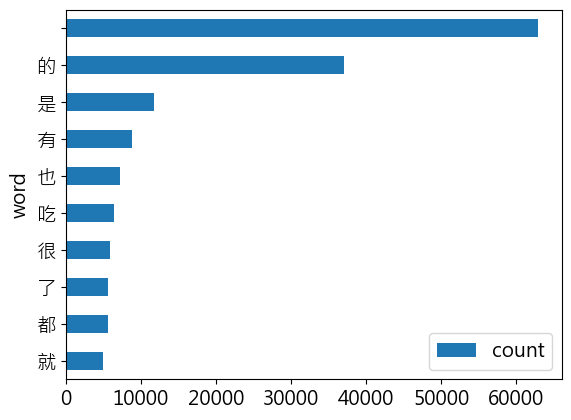

In [65]:
freq_df.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

#### 繪製文字雲

In [69]:
# wordcloud的輸入須為dict，因此先將freq_df轉換成成dict
freq_dict = freq_df.set_index('word').to_dict()
freq_dict = freq_dict['count'] # 取得 count 對應的內部字典

print(dict(list(freq_dict.items())[:10]))

{' ': 62909, '的': 37082, '是': 11776, '有': 8768, '也': 7225, '吃': 6415, '很': 5906, '了': 5656, '都': 5610, '就': 5012}


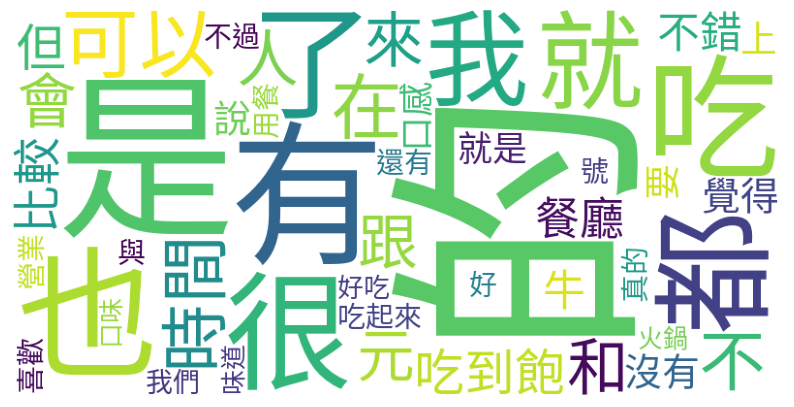

In [71]:
# 繪製文字雲
wordcloud = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words = 50)
wordcloud.generate_from_frequencies(freq_dict)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

發現斷詞有許多一個字的結果，這些字對後續分析沒有意義，因此先去除斷詞結果少於兩個字的資料。

In [72]:
#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

計算詞頻並繪製長條圖

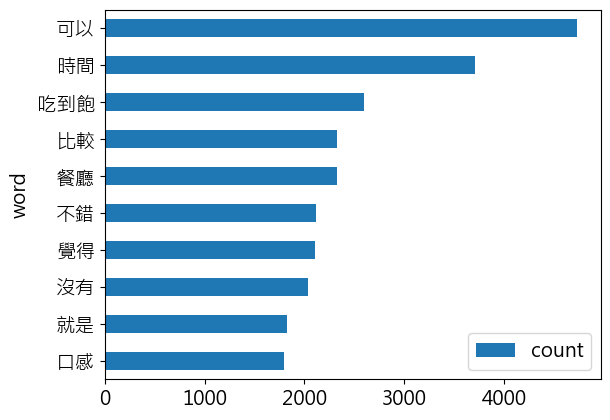

In [73]:
freq_df = pd.DataFrame(word_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()

freq_df.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()

plt.show()

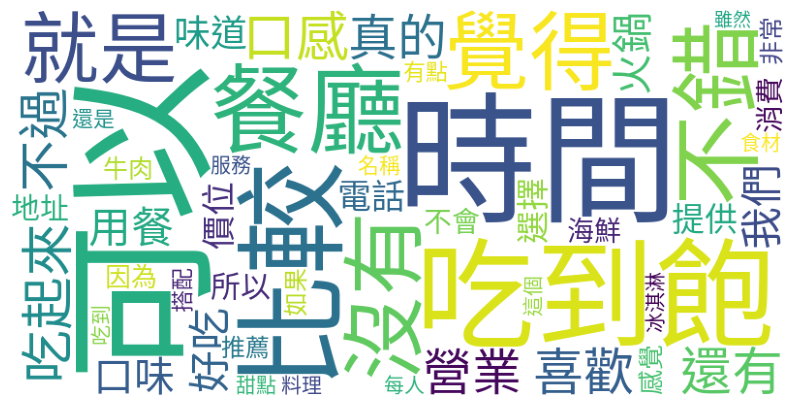

In [74]:
# wordcloud的輸入須為dict，因此先將freq_df轉換成成dict
freq_dict = freq_df.set_index('word').to_dict()
freq_dict = freq_dict['count']

# 繪製文字雲
wordcloud_no1 = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words = 50)
wordcloud_no1.generate_from_frequencies(freq_dict)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_no1)
plt.axis('off')
plt.show()

### 4.7 移除停用字

目前資料中還是有許多對後續分析沒有幫助的無意義詞彙，這些詞稱為停用字，接下來會清除這些停用字。

In [75]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 

移除dataframe中的停用字

In [76]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]

noStop_df.head(10)

,artTitle,artDate,artContent,word
0,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,餐廳
0,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,名稱
0,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,咖哩
1,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,消費
1,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,時間
1,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,2019
1,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,112
2,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,2010
3,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,提供
3,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,文章


### 計算去除停用字後的詞頻

#### 再次繪製長條圖

C:\Users\paul\AppData\Local\Temp\ipykernel_9380\583685406.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df_nostop = pd.DataFrame(pd.value_counts(noStop_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()


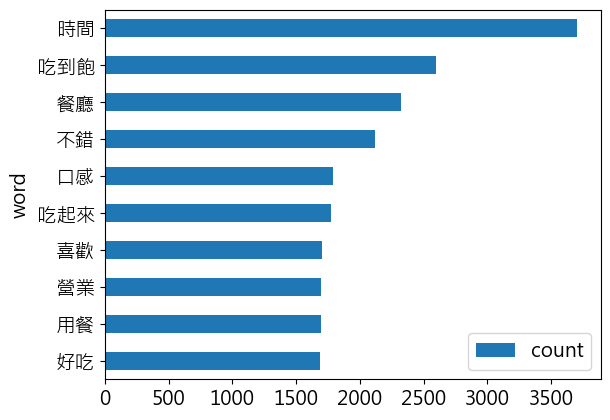

In [77]:
freq_df_nostop = pd.DataFrame(pd.value_counts(noStop_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()

freq_df_nostop.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

#### 再次繪製文字雲

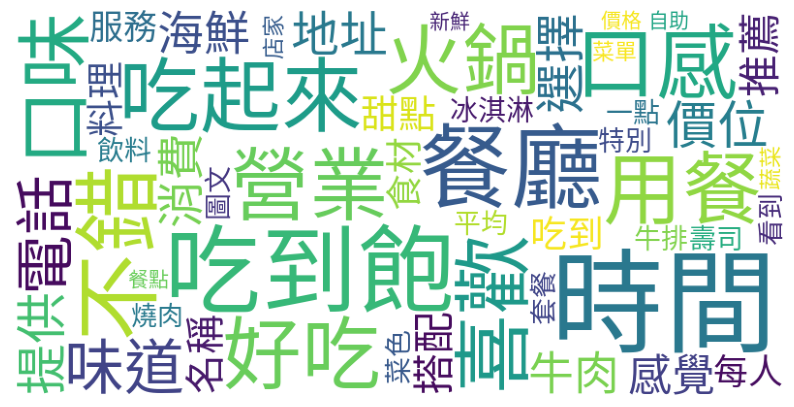

In [78]:
freq_dict_nostop = freq_df_nostop.set_index('word').to_dict()
freq_dict_nostop = freq_dict_nostop['count']

# 繪製文字雲
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words = 50)
wordcloud_nostop.generate_from_frequencies(freq_dict_nostop)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

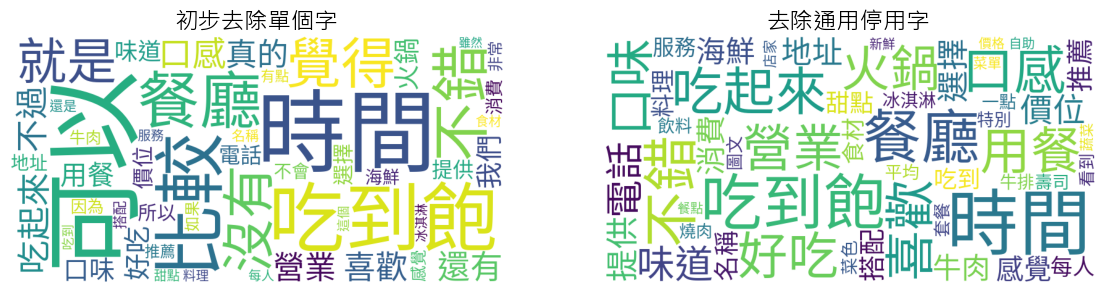

In [79]:
plt.figure(figsize = (14,8))

plt.subplot(1,2,1)
plt.imshow(wordcloud_no1)
plt.axis('off')
plt.title("初步去除單個字")

plt.subplot(1,2,2)
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.title("去除通用停用字")

plt.show()

### 4.8 更新停用字字典

In [81]:
# 參數形式手動加入停用字
stopwords_manual = ["吃到飽", "餐廳", "名稱", "消費", "時間", "地址", "營業", "吃起來", "一點", "電話", "每人", "平均", "價位", "吃到", "看到", "XD"]
stopwords.extend(stopwords_manual)

In [82]:
noStop_df_2 = noStop_df[~noStop_df['word'].isin(stopwords)]
noStop_df_2.head(10)

,artTitle,artDate,artContent,word
0,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,咖哩
1,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,2019
1,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,112
2,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,2010
3,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,提供
3,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,文章
3,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,不予
3,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,保留
4,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,多訪
4,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,綜合


#### 再次繪製文字雲

C:\Users\paul\AppData\Local\Temp\ipykernel_9380\1032659861.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df_nostop_2 = pd.DataFrame(pd.value_counts(noStop_df_2['word'])).sort_values(by = ['count'], ascending = False).reset_index()


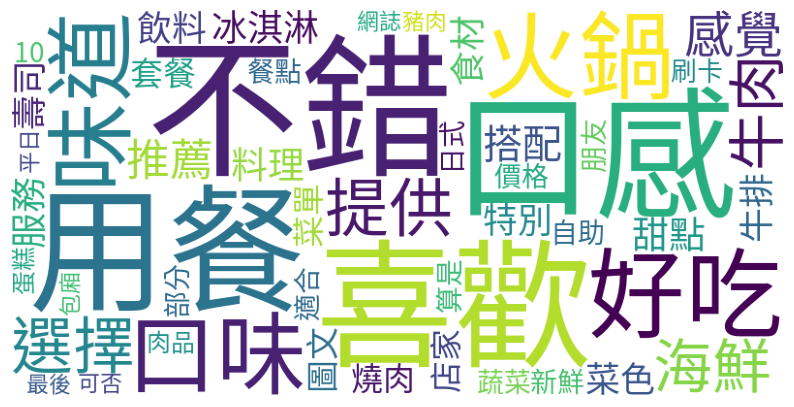

In [83]:
# 計算詞頻
freq_df_nostop_2 = pd.DataFrame(pd.value_counts(noStop_df_2['word'])).sort_values(by = ['count'], ascending = False).reset_index()

# wordcloud的輸入須為dict，因此先將freq_df轉換成成dict
freq_dict_nostop_2 = freq_df_nostop_2.set_index('word').to_dict()
freq_dict_nostop_2 = freq_dict_nostop_2['count']

# 繪製文字雲
wordcloud_nostop_2 = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words = 50)
wordcloud_nostop_2.generate_from_frequencies(freq_dict_nostop_2)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_nostop_2)
plt.axis('off')
plt.show()

透過文字雲看一下目前為止做的文字處理結果有什麼差異

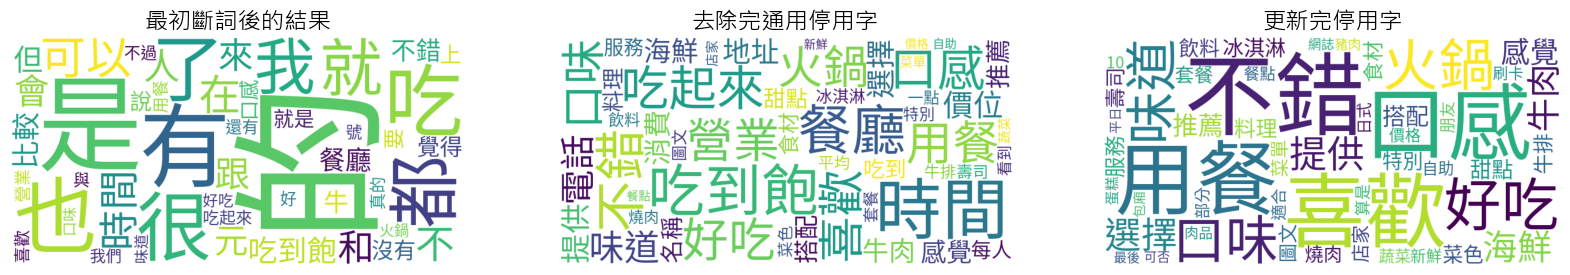

In [84]:
plt.figure(figsize = (20,14))

plt.subplot(1,3,1)
plt.imshow(wordcloud)
plt.axis('off')
plt.title("最初斷詞後的結果")

plt.subplot(1,3,2)
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.title("去除完通用停用字")

plt.subplot(1,3,3)
plt.imshow(wordcloud_nostop_2)
plt.axis('off')
plt.title("更新完停用字")

plt.show()

### 4.9 更新斷詞字典
更新斷詞字典有兩種方法

a. 自行定義的斷詞字典

In [85]:
# 載入自定義辭典：一個詞一行，每行分詞語、詞頻(可省)、詞性(可省)
jieba.load_userdict("dict/user_dict.txt")

b. 參數形式手動加入字詞

In [86]:
jieba.add_word('日式料理')
jieba.add_word('麻辣火鍋')

以 ’麻辣火鍋‘ 詞彙為範例，在重新斷詞前先查看目前 ‘麻辣火鍋‘ 出現的次數

In [88]:
# 查看目前‘麻辣火鍋’出現幾次
noStop_df_2[noStop_df_2['word'] == ('麻辣火鍋')]['word'].count()

0

#### 重新斷詞

In [89]:
# sent_df是還沒斷詞過的df
word_df_updated = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#把長度小於1的row刪掉
word_df_updated = word_df_updated.loc[word_df_updated['word'].str.len()>1]
word_df_updated

,artTitle,artDate,artContent,word
0,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,餐廳
0,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,名稱
0,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,濃咖哩
1,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,消費
1,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,時間
...,...,...,...,...
129065,[食記]高雄苓雅｜頂鮮台南擔仔麵＿道地台菜料理,2022-12-30 12:28:11,餐廳名稱：頂鮮台南擔仔麵（高雄店）\r\n 消費時間：2022年12月\r\n 地址...,價位
129065,[食記]高雄苓雅｜頂鮮台南擔仔麵＿道地台菜料理,2022-12-30 12:28:11,餐廳名稱：頂鮮台南擔仔麵（高雄店）\r\n 消費時間：2022年12月\r\n 地址...,600
129065,[食記]高雄苓雅｜頂鮮台南擔仔麵＿道地台菜料理,2022-12-30 12:28:11,餐廳名稱：頂鮮台南擔仔麵（高雄店）\r\n 消費時間：2022年12月\r\n 地址...,800
129067,[食記]高雄苓雅｜頂鮮台南擔仔麵＿道地台菜料理,2022-12-30 12:28:11,餐廳名稱：頂鮮台南擔仔麵（高雄店）\r\n 消費時間：2022年12月\r\n 地址...,完整


#### 重新移除停用字

In [90]:
nostop_df_updated = word_df_updated[~word_df_updated['word'].isin(stopwords)]

nostop_df_updated

,artTitle,artDate,artContent,word
0,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,濃咖哩
1,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,2019
1,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,112
2,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,2010
3,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,提供
...,...,...,...,...
129064,[食記]高雄苓雅｜頂鮮台南擔仔麵＿道地台菜料理,2022-12-30 12:28:11,餐廳名稱：頂鮮台南擔仔麵（高雄店）\r\n 消費時間：2022年12月\r\n 地址...,1130140017302130
129065,[食記]高雄苓雅｜頂鮮台南擔仔麵＿道地台菜料理,2022-12-30 12:28:11,餐廳名稱：頂鮮台南擔仔麵（高雄店）\r\n 消費時間：2022年12月\r\n 地址...,600
129065,[食記]高雄苓雅｜頂鮮台南擔仔麵＿道地台菜料理,2022-12-30 12:28:11,餐廳名稱：頂鮮台南擔仔麵（高雄店）\r\n 消費時間：2022年12月\r\n 地址...,800
129067,[食記]高雄苓雅｜頂鮮台南擔仔麵＿道地台菜料理,2022-12-30 12:28:11,餐廳名稱：頂鮮台南擔仔麵（高雄店）\r\n 消費時間：2022年12月\r\n 地址...,完整


In [91]:
# 查看目前‘麻辣火鍋’出現幾次
nostop_df_updated[nostop_df_updated['word'] == ('麻辣火鍋')]['word'].count()

45

將字詞加入斷詞字典中可以設定該詞的詞頻，如果一個新詞的詞頻較高，它將更有可能被視為一個獨立的單詞，而不是被切分為多個子詞。   

接下來我們試試看在斷詞字典中加入詞頻的話會怎麼樣

In [92]:
jieba.del_word('麻辣火鍋') # 先將‘麻辣火鍋’字詞從斷詞字典中移除
jieba.add_word('麻辣火鍋', freq = 100)  # 加上詞頻後重新加入斷詞字典

重新進行斷詞及清除停用字

In [94]:
# sent_df是還沒斷詞過的df
word_df_updated = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#把長度小於1的row刪掉
word_df_updated = word_df_updated.loc[word_df_updated['word'].str.len()>1]

#去除停用字
nostop_df_updated = word_df_updated[~word_df_updated['word'].isin(stopwords)]

nostop_df_updated.head(10)

,artTitle,artDate,artContent,word
0,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,濃咖哩
1,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,2019
1,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,112
2,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,2010
3,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,提供
3,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,文章
3,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,不予
3,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,保留
4,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,多訪
4,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,綜合


In [95]:
# 查看調整詞頻之後‘麻辣火鍋’出現幾次
nostop_df_updated[nostop_df_updated['word'] == ('麻辣火鍋')]['word'].count()

50

經過比對可以看到該詞的數量上升，代表該詞更加精準地被拆分了出來。

#### 重新計算詞頻

In [96]:
freq_df_updated = pd.DataFrame(pd.value_counts(nostop_df_updated['word'])).sort_values(by = ['count'], ascending = False).reset_index()

freq_df_updated.head(10)

C:\Users\paul\AppData\Local\Temp\ipykernel_9380\1450957720.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df_updated = pd.DataFrame(pd.value_counts(nostop_df_updated['word'])).sort_values(by = ['count'], ascending = False).reset_index()


,word,count
0,不錯,2117
1,口感,1793
2,喜歡,1706
3,用餐,1695
4,好吃,1687
5,口味,1572
6,火鍋,1567
7,味道,1563
8,提供,1535
9,選擇,1493


#### 重新繪製詞頻長條圖

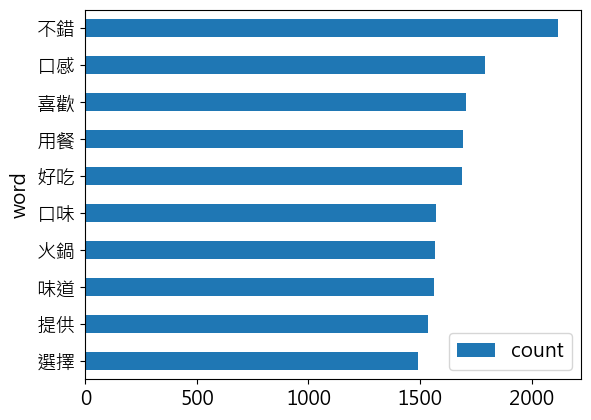

In [97]:
freq_df_updated.head(10).plot.barh(x='word', y='count').invert_yaxis()
plt.show()

#### 繪製文字雲

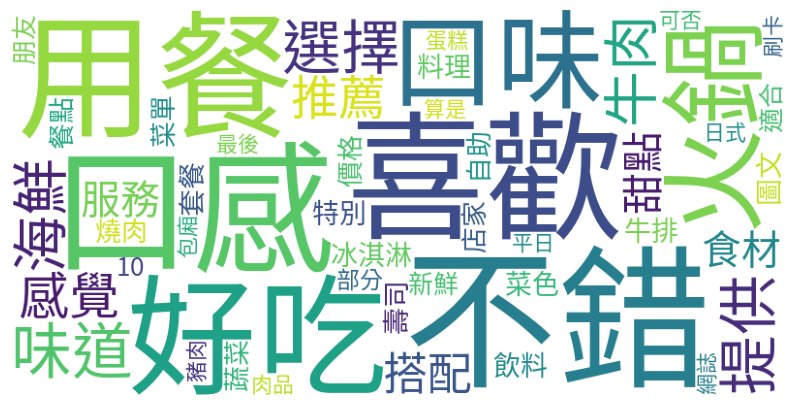

In [98]:
freq_dict_updated = freq_df_updated.set_index('word').to_dict()
freq_dict_updated = freq_dict_updated['count']

# 繪製文字雲
wordcloud_after = WordCloud(background_color='white', width=800, height = 400, font_path = FontPath, max_words = 50)
wordcloud_after.generate_from_frequencies(freq_dict_updated)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_after)
plt.axis('off')
plt.show()

### 4.10 比較清理前後的文字雲

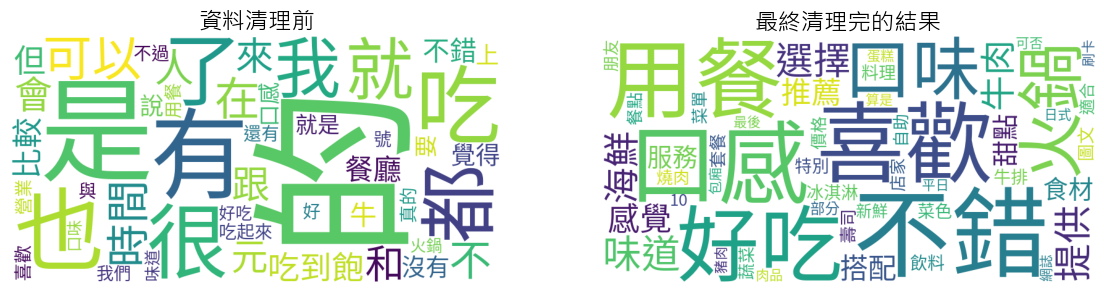

In [99]:
plt.figure(figsize = (14,8))

plt.subplot(1,2,1)
plt.imshow(wordcloud)
plt.axis('off')
plt.title("資料清理前")

plt.subplot(1,2,2)
plt.imshow(wordcloud_after)
plt.axis('off')
plt.title("最終清理完的結果")

plt.show()

儲存clean data，以便後續其他使用

In [101]:
nostop_df_updated.to_csv("raw_data/clean_zh_data.csv", encoding = 'utf-8',index = False)

資料清理的過程往往是花費做多時間的工程，因為在做完第一次的斷詞、正規化、清除停用字後，我們會發現還是會有許多不重要的字沒有被清理到，或是有些兩個字以上的專有名詞、名詞片語被斷開，因此在進行資料分析前，必須不斷經歷以上過程，更新停用字、字典，以便在後續的分析中能得到重要且正確的分析結果